In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from PIL import Image, ImageDraw

In [9]:
class EdgeBoxes():
    def __init__(self, model_path, max_boxes=30):
        self.edge_detection = cv.ximgproc.createStructuredEdgeDetection(model_path)
        self.edge_boxes = cv.ximgproc.createEdgeBoxes()
        self.edge_boxes.setMaxBoxes(30)

    def __call__(self, image, ret_scores=False):
        cv_img = transforms.PILToTensor()(image)
        cv_img = cv_img.permute((1,2,0)).numpy()
        rgb_im = cv.cvtColor(cv_img, cv.COLOR_BGR2RGB)
        edges = self.edge_detection.detectEdges(np.float32(rgb_im) / 255.0)
        orimap = self.edge_detection.computeOrientation(edges)
        edges = self.edge_detection.edgesNms(edges, orimap)
        boxes = self.edge_boxes.getBoundingBoxes(edges, orimap)

        # OpenCV returns (x, y, w, h). Shift to be (x1, y1, x2, y2)
        for b in boxes[0]:
            b[2] += b[0]
            b[3] += b[1]
            
        if ret_scores:
            return boxes[0], boxes[1]
        
        return boxes[0]

In [3]:
voc_set = datasets.VOCDetection('../../../data/', download=False)

In [4]:
image, label = voc_set[2]

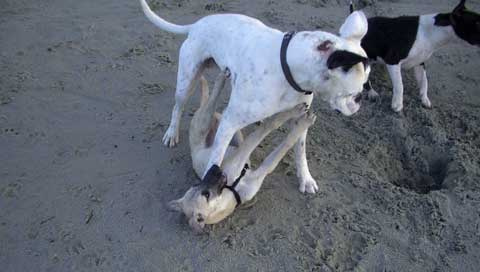

In [5]:
image

In [6]:
label

{'annotation': {'folder': 'VOC2012',
  'filename': '2008_000019.jpg',
  'source': {'database': 'The VOC2008 Database',
   'annotation': 'PASCAL VOC2008',
   'image': 'flickr'},
  'size': {'width': '480', 'height': '272', 'depth': '3'},
  'segmented': '1',
  'object': [{'name': 'dog',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'bndbox': {'xmin': '139', 'ymin': '2', 'xmax': '372', 'ymax': '197'},
    'difficult': '0'},
   {'name': 'dog',
    'pose': 'Unspecified',
    'truncated': '0',
    'occluded': '0',
    'bndbox': {'xmin': '165', 'ymin': '66', 'xmax': '318', 'ymax': '236'},
    'difficult': '0'},
   {'name': 'dog',
    'pose': 'Right',
    'truncated': '1',
    'occluded': '0',
    'bndbox': {'xmin': '361', 'ymin': '1', 'xmax': '480', 'ymax': '112'},
    'difficult': '0'}]}}

First, ensure that the boxes are generated correctly:

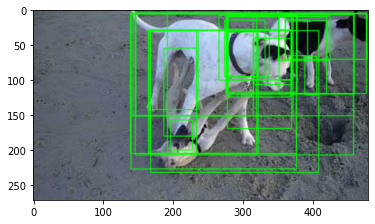

In [11]:
edge_boxes = EdgeBoxes('../edge_boxes_model/model.yml.gz')
boxes, scores = edge_boxes(image, ret_scores=True)
cv_img_drawn = transforms.PILToTensor()(image)
cv_img_drawn = cv_img_drawn.permute((1,2,0)).numpy()
for b in boxes:
    x1, y1, x2, y2 = b
    cv.rectangle(cv_img_drawn, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)
plt.imshow(cv_img_drawn)

Next, I want to try using pytorch's minumum suppression function, so we must convert things to tensors

In [12]:
tensor_boxes = transforms.ToTensor()(boxes.astype('float')).view([len(scores), 4])
tensor_scores = transforms.ToTensor()(scores.astype('float')).view(-1)

In [13]:
scores

array([[0.11577462],
       [0.11441315],
       [0.11041145],
       [0.10793789],
       [0.10569588],
       [0.1031131 ],
       [0.10297726],
       [0.1025139 ],
       [0.1022538 ],
       [0.10197817],
       [0.10146555],
       [0.09848381],
       [0.09773764],
       [0.09713987],
       [0.09474966],
       [0.09453643],
       [0.09439746],
       [0.09342023],
       [0.09006497],
       [0.08889832],
       [0.08811281],
       [0.08730239],
       [0.08727818],
       [0.08687937],
       [0.08612715],
       [0.08564733],
       [0.08564027],
       [0.08514179],
       [0.08423755],
       [0.08411751]], dtype=float32)

In [14]:
keep = torchvision.ops.nms(tensor_boxes, tensor_scores, 0.4).numpy()

In [15]:
keep

array([ 0,  1,  2,  7, 10, 15, 16, 23, 25, 27], dtype=int64)

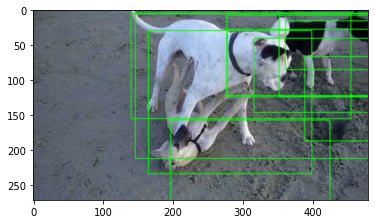

In [16]:
cv_img_drawn = transforms.PILToTensor()(image)
cv_img_drawn = cv_img_drawn.permute((1,2,0)).numpy()
for keep_idx in keep:
    x, y, w, h = boxes[keep_idx]
    cv.rectangle(cv_img_drawn, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA)
plt.imshow(cv_img_drawn)


In [66]:
class CustomVOC(datasets.VOCDetection):
    """Custom dataset that also generates boxes for each image"""
    def __init__(self, edge_model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.edge_boxes = EdgeBoxes(edge_model)
        self.label_names = [
            'background',
            'aeroplane',
            'bicycle',
            'bird',
            'boat',
            'bottle',
            'bus',
            'car',
            'cat',
            'chair',
            'cow',
            'diningtable',
            'dog',
            'horse',
            'motorbike',
            'person',
            'pottedplant',
            'sheep',
            'sofa',
            'train',
            'tvmonitor'
        ]

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        boxes = self.edge_boxes(image)

        one_hot_label = torch.ones(20) * -1
        for obj in label['annotation']['object']:
            self.label_names.index(obj['name'])
            one_hot_label[self.label_names.index(obj['name'])] = 1

        return image, one_hot_label, boxes

    def draw_boxes(self, image, boxes):
        cv_img_drawn = transforms.PILToTensor()(image)
        cv_img_drawn = cv_img_drawn.permute((1,2,0)).numpy()
        for b in boxes:
            x1, y1, x2, y2 = b
            cv.rectangle(cv_img_drawn, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)

        return Image.fromarray(cv_img_drawn)

In [44]:
custom_voc_set = CustomVOC('../edge_boxes_model/model.yml.gz', '../../../data/', download=False)

In [45]:
img, label, boxes = custom_voc_set[2]

In [46]:
label

tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
        -1., -1., -1., -1., -1., -1.])

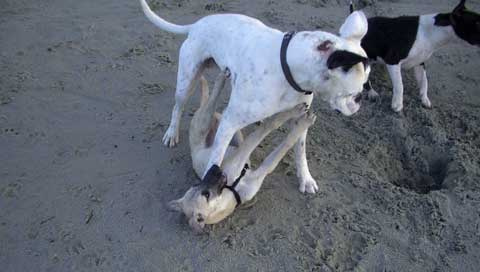

In [47]:
img

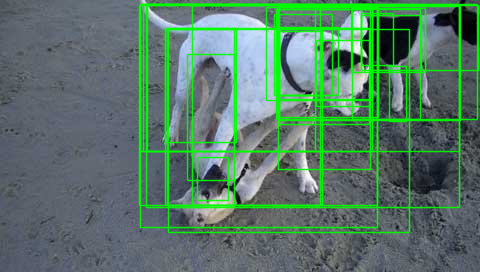

In [21]:
custom_voc_set.draw_boxes(image, boxes)

Experiment with the correct way to crop the image using splicing of tensors

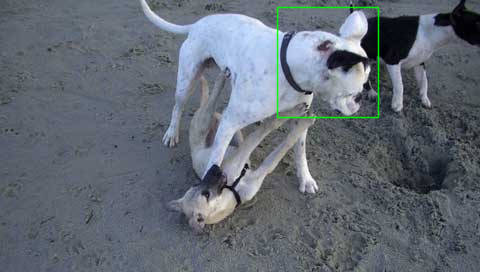

In [22]:
cv_img_drawn = transforms.PILToTensor()(image)
cv_img_drawn = cv_img_drawn.permute((1,2,0)).numpy()
x1, y1, x2, y2 = boxes[0]
cv.rectangle(cv_img_drawn, (x1, y1), (x2, y2), (0, 255, 0), 1, cv.LINE_AA)
Image.fromarray(cv_img_drawn)

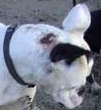

In [24]:
img_tensor = transforms.PILToTensor()(image)
transforms.ToPILImage()(img_tensor[:, y1:y2, x1:x2]) # Note that x,y are flipped

Next, see how to get the VGG feature extractor, pretrained on ImageNet

In [25]:
vgg_backbone = torchvision.models.vgg16(pretrained=True)

In [26]:
vgg_backbone

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Creating the Model

In [48]:
class WSDDN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        vgg_backbone = torchvision.models.vgg16(pretrained=True)
        self.features = vgg_backbone.features[:-1]
        self.fcs = vgg_backbone.classifier[:-1] # 25088 -> 4096
        # Class level (_c) and detection level (_d) layers
        self.fc_c = nn.Linear(4096, num_classes)
        self.fc_d = nn.Linear(4096, num_classes)


    def forward(self, x, boxes):
        x = self.features(x)

        x = torchvision.ops.roi_pool(x, boxes, (7,7), 1.0 / 16)
        x = x.view(x.shape[0], -1)

        x = self.fcs(x)
        x_c = F.softmax(self.fc_c(x), dim=1)
        x_d = F.softmax(self.fc_d(x), dim=0)

        scores = x_c * x_d
        # print(x_c.shape)
        # print(x_d.shape)
        # print(scores.shape)
        # NMS here? or is that just evaluation time
        return scores
        
    @staticmethod
    def calculate_loss(combined_scores, target):
        image_level_scores = torch.sum(combined_scores, dim=0)
        image_level_scores = torch.clamp(image_level_scores, min=0.0, max=1.0)
        loss = F.binary_cross_entropy(image_level_scores, target, reduction="sum")
        return loss

    def spatial_pyramid_pool(self, previous_conv, num_sample, previous_conv_size, out_pool_size):
        # Source: https://github.com/yueruchen/sppnet-pytorch/blob/master/cnn_with_spp.py
        '''
        previous_conv: a tensor vector of previous convolution layer
        num_sample: an int number of image in the batch
        previous_conv_size: an int vector [height, width] of the matrix features size of previous convolution layer
        out_pool_size: a int vector of expected output size of max pooling layer
        
        returns: a tensor vector with shape [1 x n] is the concentration of multi-level pooling
        '''    
        # print(previous_conv.size())
        for i in range(len(out_pool_size)):
            # print(previous_conv_size)
            h_wid = int(math.ceil(previous_conv_size[0] / out_pool_size[i]))
            w_wid = int(math.ceil(previous_conv_size[1] / out_pool_size[i]))
            h_pad = (h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2
            w_pad = (w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2
            maxpool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(h_pad, w_pad))
            x = maxpool(previous_conv)
            if (i == 0):
                spp = x.view(num_sample,-1)
                # print("spp size:",spp.size())
            else:
                # print("size:",spp.size())
                spp = torch.cat((spp,x.view(num_sample,-1)), 1)
        
        return spp

In [67]:
custom_voc_set = CustomVOC('../edge_boxes_model/model.yml.gz', '../../../data/', download=False, image_set='train')

In [68]:
image, label, boxes = custom_voc_set[4]

In [69]:
net = WSDDN(20)

In [70]:
image_tensor = transforms.ToTensor()(image)
image_tensor = image_tensor.reshape([1, image_tensor.shape[0], image_tensor.shape[1], image_tensor.shape[2]])
boxes_tensor = transforms.ToTensor()(boxes.astype('float32')).view([len(boxes), 4])
boxes_tensor = [boxes_tensor]#.reshape([1, boxes_tensor.shape[0], boxes_tensor.shape[1]])
forward = net(image_tensor, boxes_tensor)
forward.shape

torch.Size([30, 20])

In [71]:
net.calculate_loss(forward, label)

tensor(-51.9125, grad_fn=<BinaryCrossEntropyBackward>)